# Baseline Models

In [1]:
import numpy as np # Use version 1.x not 2.x
import random
import pandas as pd

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
import pickle

def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    records = []
    for company, periods in data.items():
        for period, (features, rating) in periods.items():
            record = {
                'company': company,
                'period': period,
                **{f'feature_{i}': feature.item() for i, feature in enumerate(features)},
                'rating': int(rating.item())
            }
            records.append(record)

    return pd.DataFrame(records)

In [3]:
# needed for XGBoost
def encode_labels(y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    test_labels = np.unique(y_test)
    new_labels = np.setdiff1d(test_labels, label_encoder.classes_)
    if new_labels.size > 0:
        label_encoder.classes_ = np.append(label_encoder.classes_, new_labels)
    
    y_test_encoded = label_encoder.transform(y_test)
    
    return y_train_encoded, y_test_encoded

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

train_df = load_data('./data/train_dict.pkl')
test_df = load_data('./data/test_dict.pkl')

X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train, y_test = encode_labels(y_train, y_test)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=RANDOM_SEED),
    'k-NN (k=1)': KNeighborsClassifier(n_neighbors=1),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=RANDOM_SEED),
    'LDA': LinearDiscriminantAnalysis(),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_SEED, verbose = -1)
}

print('Train-Test Split Accuracy Results')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name:20}: {accuracy:.4f}')

Train-Test Split Accuracy Results
Decision Tree       : 0.1499
Random Forest       : 0.1199
Logistic Regression : 0.1667
k-NN (k=1)          : 0.1139
Naive Bayes         : 0.1259
SVM                 : 0.1547
LDA                 : 0.1595
XGBoost             : 0.1775
LightGBM            : 0.1679


#### Class Distribution

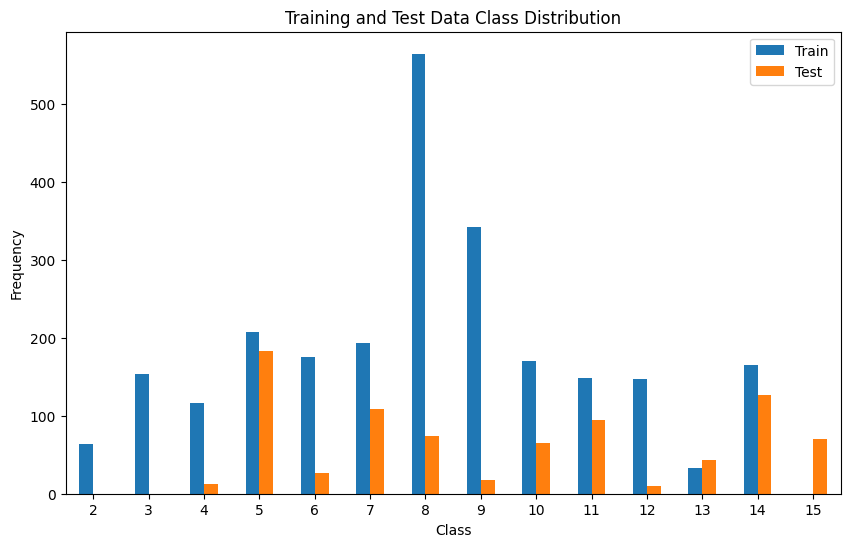

In [6]:
import matplotlib.pyplot as plt

def plot_class_distribution(y_train, y_test, title):
    plt.figure(figsize=(10, 6))
    train_counts = y_train.value_counts().sort_index()
    test_counts = y_test.value_counts().sort_index()
    
    df_plot = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)
    df_plot.plot(kind='bar', ax=plt.gca())
    
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.legend(['Train', 'Test'])
    plt.show()

plot_class_distribution(train_df['rating'], test_df['rating'], 'Training and Test Data Class Distribution')

In [7]:
from scipy.stats import chi2_contingency

train_label_counts = train_df['rating'].value_counts()
test_label_counts = test_df['rating'].value_counts()

observed = pd.DataFrame({'Train': train_label_counts, 'Test': test_label_counts}).fillna(0)
chi2, p, dof, expected = chi2_contingency(observed.T)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("The difference in class distributions between training and test datasets is statistically significant.")
else:
    print("The difference in class distributions between training and test datasets is not statistically significant.")


Chi-square statistic: 716.6176512874111
P-value: 9.64606125587922e-145
The difference in class distributions between training and test datasets is statistically significant.


#### Feature Distributrion

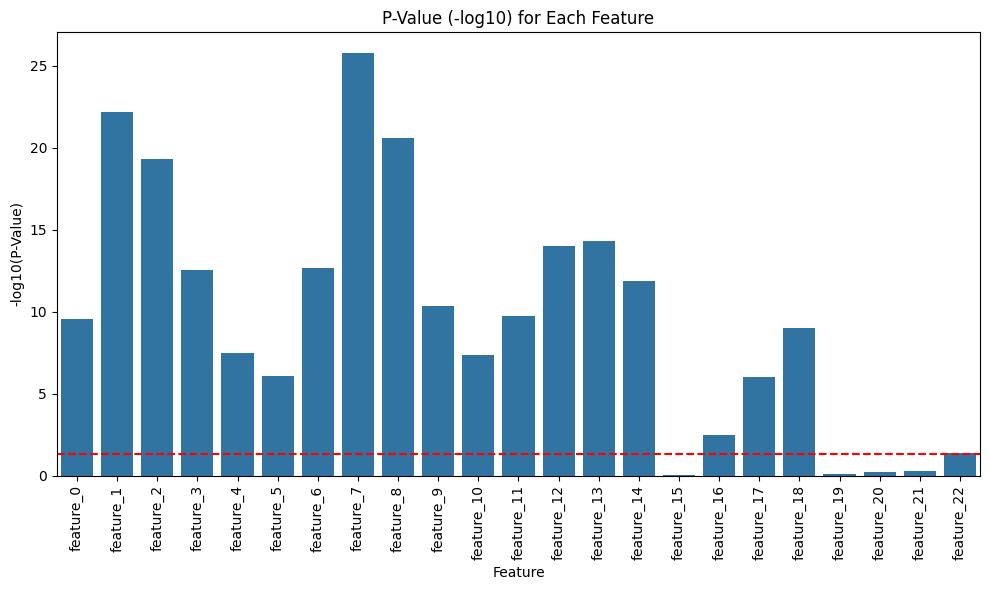

In [8]:
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns

numeric_features = train_df.select_dtypes(include=['float64']).columns

t_test_results = []

for feature in numeric_features:
    t_stat, p_value = ttest_ind(train_df[feature], test_df[feature])
    t_test_results.append({'feature': feature, 't_statistic': t_stat, 'p_value': p_value})

t_test_df = pd.DataFrame(t_test_results)

t_test_df['-log10(p_value)'] = -np.log10(t_test_df['p_value'])

plt.figure(figsize=(10, 6))

sns.barplot(x='feature', y='-log10(p_value)', data=t_test_df)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.xticks(rotation=90)
plt.title('P-Value (-log10) for Each Feature')
plt.xlabel('Feature')
plt.ylabel('-log10(P-Value)')

plt.tight_layout()
plt.show()

### Predict newer data (20%) from older data (80%)

In [9]:
def split_by_period(df):
    split_index = int(len(df) * 0.8)
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df = merged_df.sort_values(by=['company', 'period'])

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for company, group in merged_df.groupby('company'):
    train_data, test_data = split_by_period(group)
    train_df = pd.concat([train_df, train_data])
    test_df = pd.concat([test_df, test_data])

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [10]:
train_df.iloc[41:46]

,company,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,rating
41,ADM,2020Q4,27286.000000,22433.000000,49719.000000,6556.000000,16377.000000,11713.000000,18182.000000,11441.000000,...,0.089053,0.038213,1.500715,0.856506,0.360576,2.483218,0.025178,0.034312,1.398190,5
42,ADM,2021Q1,29284.000000,22194.000000,51478.000000,7097.000000,17096.000000,12764.000000,18512.000000,12023.000000,...,0.095115,0.036469,1.581893,0.892394,0.383373,2.467667,0.023528,0.033028,1.339392,5
43,ADM,2021Q2,28504.000000,22454.000000,50958.000000,7983.000000,21220.000000,11446.000000,17296.000000,11988.000000,...,0.074413,0.031056,1.648011,0.986240,0.461552,2.358839,0.024979,0.032958,1.853923,5
44,AKO.B,2013Q4,876.952026,3089.006104,3965.958008,215.352997,452.334991,239.626007,765.682007,1522.027954,...,0.447321,0.073320,1.145321,0.832364,0.281256,2.363154,0.068428,0.035756,1.887671,8
45,AKO.B,2014Q1,786.869995,3059.429932,3846.300049,196.498001,440.343994,237.675003,632.206970,1513.438965,...,0.460017,0.054281,1.244640,0.868695,0.310813,2.261659,0.056255,0.026028,1.852715,8


In [11]:
test_df.head()

,company,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,rating
0,ADM,2021Q3,29290.0,23008.0,52298.0,8974.0,18767.0,11169.0,18576.0,11507.0,...,0.077335,0.025860,1.576766,0.975506,0.483096,2.378263,0.017958,0.023920,1.680276,5
1,ADM,2021Q4,31909.0,24227.0,56136.0,8959.0,21183.0,14481.0,21948.0,11421.0,...,0.082590,0.033867,1.453846,0.794059,0.408192,2.494046,0.024507,0.034743,1.462813,5
2,ADM,2022Q1,40453.0,24413.0,64866.0,11211.0,21498.0,17290.0,28523.0,12326.0,...,0.090994,0.044567,1.418259,0.812081,0.393051,2.730625,0.026055,0.044370,1.243378,5
3,ADM,2022Q2,37647.0,24181.0,61828.0,10880.0,24927.0,14485.0,25660.0,11481.0,...,0.086388,0.045301,1.467147,0.902650,0.424006,2.531237,0.032831,0.050602,1.720884,5
4,ADM,2022Q3,34569.0,23735.0,58304.0,10444.0,22612.0,13282.0,22936.0,11049.0,...,0.083904,0.041770,1.507194,0.928104,0.455354,2.426401,0.029824,0.042906,1.702454,5


In [12]:
X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train, y_test = encode_labels(y_train, y_test)

print('Predict newer data (20%) from older data (80%) \nAccuracy Results')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name:20}: {accuracy:.4f}')

Predict newer data (20%) from older data (80%) 
Accuracy Results
Decision Tree       : 0.6758
Random Forest       : 0.8264
Logistic Regression : 0.4978
k-NN (k=1)          : 0.7805
Naive Bayes         : 0.2984
SVM                 : 0.6184
LDA                 : 0.4419
XGBoost             : 0.7791
LightGBM            : 0.8034


### Predict the most recent ratings from all past data

In [13]:
merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df = merged_df.sort_values(by=['company', 'period'])

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for company, group in merged_df.groupby('company'):
    test_data = group.iloc[-1:]
    train_data = group.iloc[:-1]
    train_df = pd.concat([train_df, train_data])
    test_df = pd.concat([test_df, test_data])

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [14]:
print(len(test_df))
print(merged_df['company'].nunique())

66
66


In [15]:
X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train, y_test = encode_labels(y_train, y_test)

print('Predict the most recent ratings from all past data \nAccuracy Results')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name:20}: {accuracy:.4f}')

Predict the most recent ratings from all past data 
Accuracy Results
Decision Tree       : 0.8788
Random Forest       : 0.9394
Logistic Regression : 0.4848
k-NN (k=1)          : 0.9091
Naive Bayes         : 0.2879
SVM                 : 0.6364
LDA                 : 0.4848
XGBoost             : 0.9242
LightGBM            : 0.9697


### Appendix: Cross-Validation

#### split by companies (GroupKFold)

In [16]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline

merged_df = pd.concat([train_df, test_df], ignore_index=True)

X = merged_df.drop(columns=['company', 'period', 'rating'])
y = merged_df['rating']

groups = merged_df['company']

gkf = GroupKFold(n_splits=5)
print('GroupKFold (5-Fold Cross-Validation) Accuracy Results')

for model_name, model in models.items():
    fold_accuracies = []
    
    for train_index, test_index in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_train, y_test = encode_labels(y_train, y_test)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        accuracy = pipeline.score(X_test, y_test)
        fold_accuracies.append(accuracy)
    
    print(f'{model_name:20}: {np.mean(fold_accuracies):.4f}')

GroupKFold (5-Fold Cross-Validation) Accuracy Results
Decision Tree       : 0.1423
Random Forest       : 0.1601
Logistic Regression : 0.1310
k-NN (k=1)          : 0.1398
Naive Bayes         : 0.1020
SVM                 : 0.1621
LDA                 : 0.1472
XGBoost             : 0.1479
LightGBM            : 0.1542


#### split by companies (StratifiedGroupKFold)

In [17]:
from sklearn.model_selection import StratifiedGroupKFold

merged_df = pd.concat([train_df, test_df], ignore_index=True)

X = merged_df.drop(columns=['company', 'period', 'rating'])
y = merged_df['rating']

groups = merged_df['company']

sgkf = StratifiedGroupKFold()
print('StratifiedGroupKFold (5-Fold Cross-Validation) Accuracy Results')

for model_name, model in models.items():
    fold_accuracies = []
    
    for train_index, test_index in sgkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_train, y_test = encode_labels(y_train, y_test)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        accuracy = pipeline.score(X_test, y_test)
        fold_accuracies.append(accuracy)
    
    print(f'{model_name:20}: {np.mean(fold_accuracies):.4f}')

StratifiedGroupKFold (5-Fold Cross-Validation) Accuracy Results
Decision Tree       : 0.1552
Random Forest       : 0.1456
Logistic Regression : 0.1529
k-NN (k=1)          : 0.1347
Naive Bayes         : 0.1190
SVM                 : 0.1607
LDA                 : 0.1601
XGBoost             : 0.1576
LightGBM            : 0.1562


#### shuffle/split by periods (data leakage?)

In [18]:
from sklearn.model_selection import KFold, cross_val_score

merged_df = pd.concat([train_df, test_df], ignore_index=True)

X = merged_df.drop(columns=['company', 'period', 'rating'])
y = merged_df['rating']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
print('5-Fold Cross-Validation (with shuffle) Accuracy Results')

for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')
    print(f'{model_name:20}: {scores.mean():.4f}')

5-Fold Cross-Validation (with shuffle) Accuracy Results
Decision Tree       : 0.8559
Random Forest       : 0.9364
Logistic Regression : 0.4976
k-NN (k=1)          : 0.8496
Naive Bayes         : 0.2930
SVM                 : 0.5769
LDA                 : 0.4253
XGBoost             : 0.9340
LightGBM            : 0.9412
